# 2水準系 直交実験の結果解析
---
**●やりたいこと：**   
今回の目的は、直交表を用いた実験計画法によって  
「複数のパラメータとその組み合わせが結果にどう影響しているかを、効率よく見極める」ことです。  
直交表を使うことのメリットについては、参考文献を参照して下さい  
  
**●具体的には**  
前回作成した2水準系直交表を用いた実験後の結果データを用いて、  
因子と交互作用の効果を可視化・分析・推定します。  
  
**● Pythonでの実装**
- 各因子、各交互作用のグラフを作成（作成済み）
- 分散分析（今回ここまで作成済み）
- 推定（未作成）


### ライブラリの読み込み

In [1]:
import pandas as pd              # DataFrame操作
import openpyxl                  # excel操作
import matplotlib.pyplot as plt  # グラフ描画
import os, sys, tkinter, tkinter.filedialog, tkinter.messagebox # ダイアログ関連
import scipy.stats as stats      # F検定用
import time                      # wait用

### グラフの表示設定

defaultではグラフの日本語表示がおかしかったため（日本語がすべて□になる）、下記の記事を参考に、　　

https://qiita.com/katuemon/items/5c4db01997ad9dc343e0  
- フォント(IPAゴシック)のインストール
- 「fontList.json」の削除

を行いました。

In [2]:
# グラフのフォント設定。日本語文字化け対策
plt.rcParams['font.family'] = 'IPAexGothic' # グラフの日本語フォント設定
# plt.rcParams['figure.figsize'] = 1,1  # デフォルトのグラフサイズ設定

# グラフのカラーマップをいい感じに変更
# Set1 https://matplotlib.org/examples/color/colormaps_reference.html
# https://stackoverflow.com/questions/46148193/how-to-set-default-matplotlib-axis-colour-cycle
from cycler import cycler
c = plt.get_cmap('Set1').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=c)

/Users/kechon_s/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
['IPAexGothic']
/Users/kechon_s/.matplotlib
/Users/kechon_s/.matplotlib


'/Users/kechon_s/.matplotlib'

### 結果データ読み込み

今回は前回作ったカレーの実験計画に、結果を記入したファイルを準備しました。
カレーの出来栄え（評価点）を5点満点として、計4回の結果を記入しています。

In [3]:
# データ読み込み。
# root = tkinter.Tk()
# root.withdraw()
# fTyp = [("Expt. Result File", ".xlsx")]
# # iDir = os.path.abspath(os.path.dirname(sys.argv[0]))  # __file__ pyファイルが存在するフォルダ
# iDir = 'YOUR_FOLDER\\jupyter⁩'  # デフォルトで開くフォルダを直接指定
# filepath = tkinter.filedialog.askopenfilenames(filetypes=fTyp)  # ファイルパス取得ダイアログ , initialdir=iDir
# path = filepath[0]

path = 'result_Expt_Plan_L4.xlsx'

print(path)

wb = openpyxl.load_workbook(path)
print(wb.sheetnames)

sheet_result = wb["Expt_Plan"]
sheet_fcts = wb["Factors"]
sheet_itrs = wb["Interactions"]

data_result = list(sheet_result.values)
df = pd.DataFrame(data_result[1:], columns=data_result[0])

data_fcts = list(sheet_fcts.values)
df_fcts = pd.DataFrame(data_fcts[1:], columns=data_fcts[0])

data_itrs = list(sheet_itrs.values)
df_itrs = pd.DataFrame(data_itrs[1:], columns=data_itrs[0])

df = df.sort_values('行No.') # 元の行Noで並べ替え
df = df.reset_index()

ls_tmp = list(df) # 列の項目名を取得
ls = ls_tmp[2:]  # 余計な列削除
print(ls)
df = df[ls]      # 同上
df

output_Expt_Plan_L4.xlsx
['Expt_Plan', 'Factors', 'Interactions']
['時間', '小麦', 'カレー粉', '結果', '備考', '行No.']


,時間,小麦,カレー粉,結果,備考,行No.
0,20,5,海軍,3.5,None,1
1,20,10,BMT,3.0,None,2
2,60,5,BMT,4.0,None,3
3,60,10,海軍,5.0,None,4


### エラー判定

In [4]:
# 結果に空欄や抜けがあればここで止める
if df["結果"].isnull().any():
    print("ERROR. 「結果」列に空欄があります")
    print(not_defined)  # エラーで強制的に止める TODO:スマートな方法があれば直す

### 因子、交互作用の抽出

In [5]:
fcts_retsuban = list(df_fcts["Col_Index"])
if len(df_itrs) != 0:
    itrs_retsuban = list(df_itrs["Col_Index"])

factors = df_fcts.iloc[:,1:3].values.tolist()
interactions = df_itrs.iloc[:,1:3].values.tolist()
print("因子", factors)
print("交互作用", interactions)

因子 [[20, 60], [5, 10], ['海軍', 'BMT']]
交互作用 []


## 効果のグラフ化
---
　　
  　　
    
### 因子の各水準の平均計算

In [6]:
# 因子の平均計算
df_mean = pd.DataFrame()
for fct_i,retsuban in enumerate(fcts_retsuban):
    mean = [0] * 2
    col_name = ls[retsuban - 1]
    for level_i in range(2):
        df_selected = df[df[col_name] == factors[fct_i][level_i]]
        df_selected_mean = df_selected.mean()
        mean[level_i] = df_selected_mean["結果"]
#     print(mean)
    df_tmp = pd.Series(mean,name=col_name)
    df_mean = pd.concat([df_mean,df_tmp],axis=1)
df_mean

,時間,小麦,カレー粉
0,3.25,3.75,4.25
1,4.50,4.00,3.50


### グラフ用、交互作用の平均計算
あまりスマートに計算出来ていない気もしますが。。

In [7]:
# 交互作用の平均計算
if len(df_itrs) != 0:
    df_mean_1 = pd.DataFrame()
    df_mean_2 = pd.DataFrame()
    itr_names = []
    for itr_i,itr in enumerate(interactions):
        mean_1 = [0] * 2
        mean_2 = [0] * 2
        itr_names.append(ls[itrs_retsuban[itr_i]-1])
        col_1 = ls[fcts_retsuban[itr[0]]-1] # A
        col_2 = ls[fcts_retsuban[itr[1]]-1]  # B

        name_1 = col_2  + "=" + str(factors[itr[1]][0])
        name_2 = col_2  + "=" + str(factors[itr[1]][1])
        for level_i in range(2):
            df_selected_1 = df[(df[col_1] == factors[itr[0]][level_i]) & (df[col_2] == factors[itr[1]][0])]
            df_selected_2 = df[(df[col_1] == factors[itr[0]][level_i]) & (df[col_2] == factors[itr[1]][1])]
            df_selected_mean_1 = df_selected_1.mean()
            df_selected_mean_2 = df_selected_2.mean()
            mean_1[level_i] = df_selected_mean_1["結果"]
            mean_2[level_i] = df_selected_mean_2["結果"]
    #     print(mean)
        df_tmp_1 = pd.Series(mean_1,name=name_1)
        df_tmp_2 = pd.Series(mean_2,name=name_2)
        df_mean_1 = pd.concat([df_mean_1,df_tmp_1],axis=1)
        df_mean_2 = pd.concat([df_mean_2,df_tmp_2],axis=1)
    print(itr_names)
    print(df_mean_1)
    print(df_mean_2)

### グラフのplot

<IPython.core.display.Javascript object>


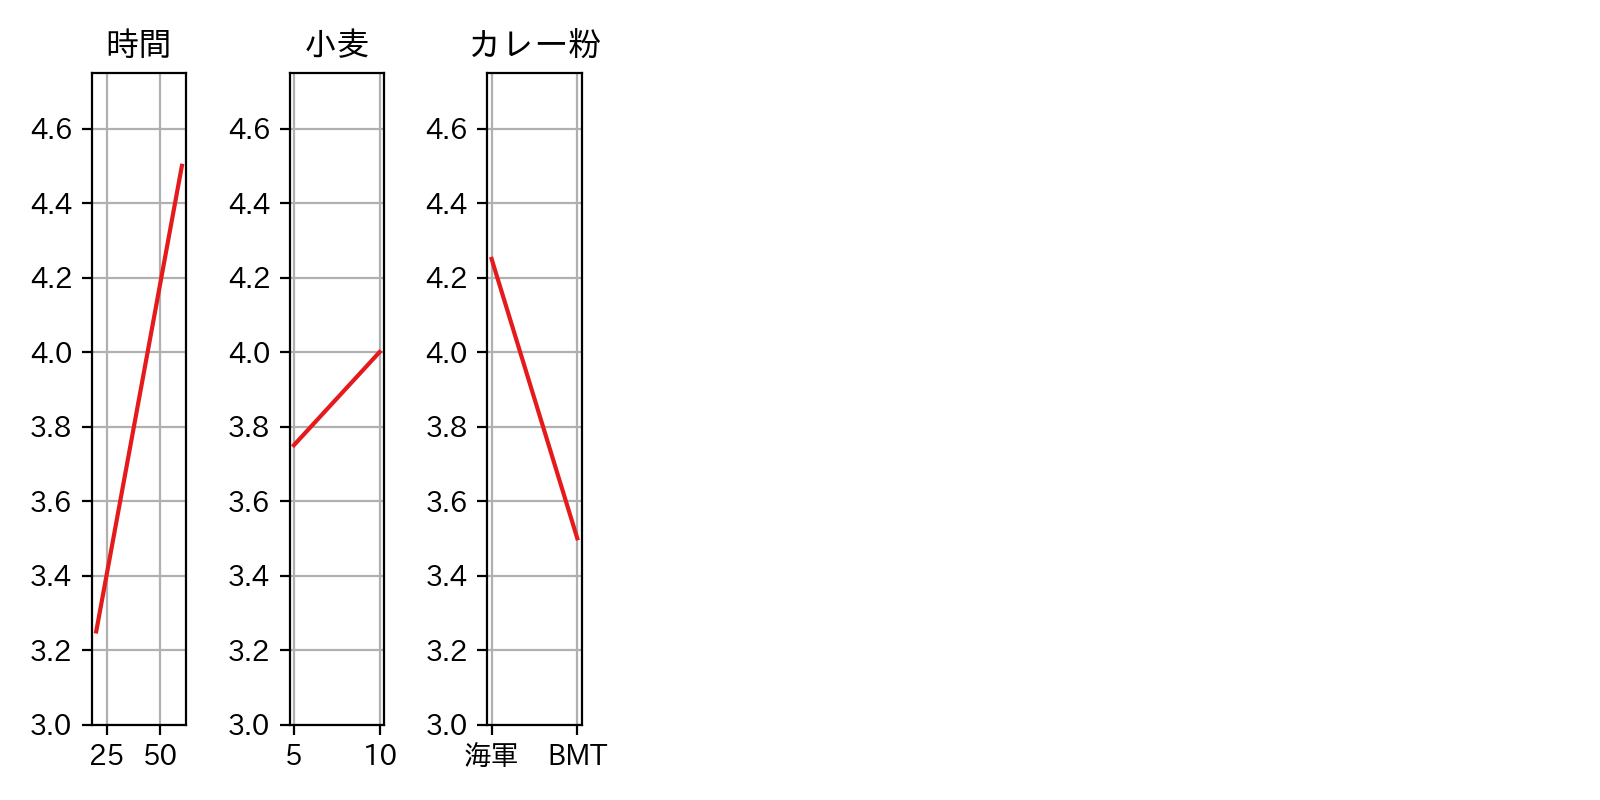

y_min =  3.25
y_max =  4.5


In [8]:
%matplotlib notebook
# 一度に複数のグラフを表示
fig = plt.figure(figsize=(8, 4),dpi=100)  # figsizeで個別のグラフサイズ、dpiで解像度を設定
graph_no = len(factors)+ len(interactions)  # グラフの数
graph_col_no = 8 # グラフの列数
graph_titles_fct = list(df_mean)
q, mod = divmod(graph_no, graph_col_no)
if mod > 0:
    graph_row_no = q + 1
else:
    graph_row_no = q

# 因子の最大最小
y_min_fct = df_mean.min().min()
y_max_fct = df_mean.max().max()

# 交互作用の最大最小
if len(df_itrs) != 0:
    df_mean_12_merged = pd.concat([df_mean_1,df_mean_2], axis=0, sort=True)
    y_min_itr = df_mean_12_merged.min().min()  # ⇒1次元⇒1個
    y_max_itr = df_mean_12_merged.max().max()

# 全ての効果の最大最小
if len(df_itrs) != 0:
    if y_min_fct <= y_min_itr:
        y_min = y_min_fct
    else:
        y_min = y_min_itr
    if y_max_fct >= y_max_itr:
        y_max = y_max_fct
    else:
        y_max = y_max_itr
else:
    y_min = y_min_fct
    y_max = y_max_fct
print("y_min = ",y_min)
print("y_max = ",y_max)

# 最大最小の差
width = y_max - y_min

# 因子の効果plot 
for i in range(0,len(factors)):
    x = factors[i]
    plt.subplot(graph_row_no,graph_col_no,i+1)
    plt.title(ls[fcts_retsuban[i]-1])
    plt.ylim([y_min - width * 0.2, y_max + width * 0.2])
    plt.plot(x,df_mean[graph_titles_fct[i]])
    plt.grid()
    
# 交互作用の効果plot 
if len(df_itrs) != 0:
    for i,itr in enumerate(interactions):
        x = factors[interactions[i][0]]
        title = ls[itrs_retsuban[i]-1]
        col_2 = ls[fcts_retsuban[itr[1]]-1]  # B
        name_1 = col_2  + "=" + str(factors[itr[1]][0])
        name_2 = col_2  + "=" + str(factors[itr[1]][1])
        plt.subplot(graph_row_no,graph_col_no,i+len(factors)+1)
        plt.title(title)
        plt.ylim([y_min - width * 0.2, y_max + width * 0.2])  # グラフの上下に20%マージンを空ける
        plt.plot(x,df_mean_1[name_1],label=name_1)
        plt.plot(x,df_mean_2[name_2],label=name_2)
        plt.grid()
        plt.legend(loc='lower center',
                  bbox_to_anchor=(0.25, -0.5, 0.5, .102)  # たぶん(x,y,width,height)
                  )  
plt.tight_layout()
time.sleep(1)  #  グラフ表示に時間がかかる場合に備えて、少しwaitを入れる

In [ ]:
最も影響が大きいのは煮込み時間、次いでカレー粉の影響が大きく、
小麦粉の量の影響は小さいとわかります。

## 分散分析
---
グラフを見ることで、因子（今回の例では交互作用はなし）の効果の概要を知ることが出来ました。  
さらに細かく統計的な情報を見たい場合には、分散分析もする必要があります。  

### 交互作用の平均計算
交互作用について、直交表の値1,2それぞれの結果の平均値を計算  
先ほどのグラフ化用データから計算する

In [9]:
if len(df_itrs) != 0:
    df_itrs_mean = pd.DataFrame()
    for i in range(len(interactions)):
        itrs_mean_1 = (df_mean_1.iloc[0,i] + df_mean_2.iloc[1,i]) / 2
        itrs_mean_2 = (df_mean_1.iloc[1,i] + df_mean_2.iloc[0,i]) / 2
        df_tmp = pd.DataFrame([itrs_mean_1, itrs_mean_2])
        df_itrs_mean = pd.concat([df_itrs_mean,df_tmp],axis=1)
    df_itrs_mean.columns = itr_names
    df_itrs_mean

### 総平均、総平方和

In [10]:
total_ave = df["結果"].mean()  # 総平均

df_tmp_ss = (df["結果"] - total_ave)**2
total_ss = df_tmp_ss.sum()  # 総平方和 sum_of_squares

print("総平均   = ", total_ave)
print("総平方和 = ", total_ss)

総平均   =  3.875
総平方和 =  2.1875


### 各因子の効果

In [11]:
df_fcts_effect = df_mean - total_ave
df_fcts_effect

,時間,小麦,カレー粉
0,-0.625,-0.125,0.375
1,0.625,0.125,-0.375


### 各交互作用の効果

In [12]:
if len(df_itrs) != 0:
    df_itrs_effect = df_itrs_mean - total_ave
    df_itrs_effect

### 各因子、交互作用、誤差の平方和を計算

In [13]:
df_fcts_mean = df_mean # TODO:統一する

df_fcts_ss = len(df) /2 * (df_fcts_effect.iloc[0] ** 2 + df_fcts_effect.iloc[1] ** 2)
print("因子の平方和\n", df_fcts_ss)

if len(df_itrs) != 0:
    df_itrs_ss = len(df) /2 * (df_itrs_effect.iloc[0] ** 2 + df_itrs_effect.iloc[1] ** 2)
    print("\n交互作用の平方和\n", df_itrs_ss)

if len(df_itrs) != 0:
    e_ss = total_ss - df_fcts_ss.sum() - df_itrs_ss.sum()
else:
    e_ss = total_ss - df_fcts_ss.sum()
print("\n誤差の平方和",e_ss)

因子の平方和
 時間      1.5625
小麦      0.0625
カレー粉    0.5625
dtype: float64

誤差の平方和 0.0


### 平方和をグラフ化

時間      1.5625
小麦      0.0625
カレー粉    0.5625
dtype: float64


<IPython.core.display.Javascript object>


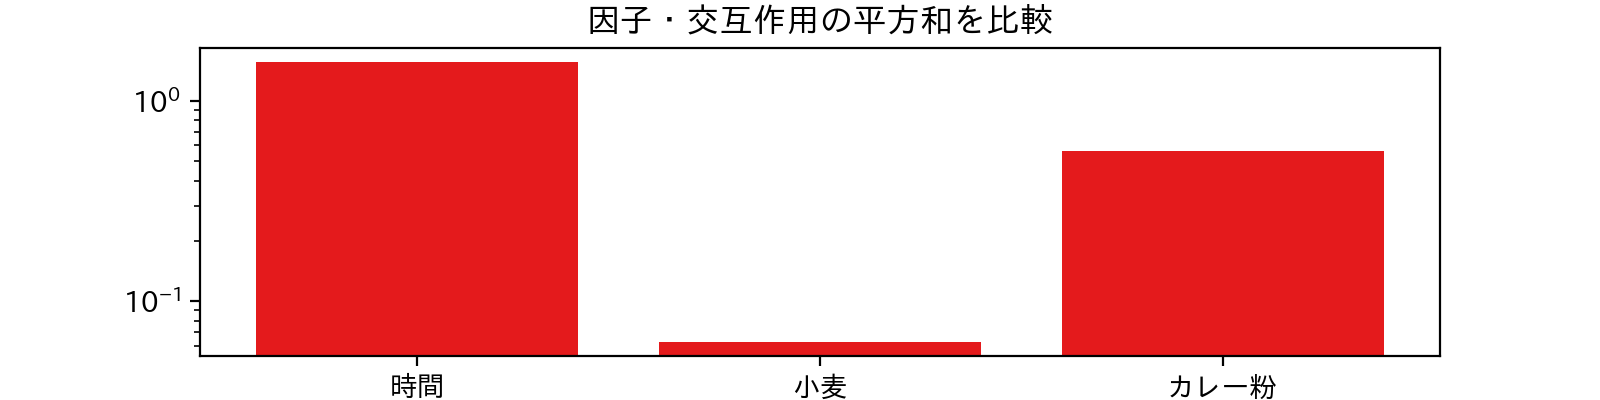

Index(['時間', '小麦', 'カレー粉'], dtype='object')

In [14]:
if len(df_itrs) != 0:
    df_ss = pd.concat([df_fcts_ss,df_itrs_ss],axis=0)
else:
    df_ss = df_fcts_ss.copy()
if "e" in ls:
    df_ss["e"] = e_ss
print(df_ss)

fig_ss = plt.figure(figsize=(8, 2),dpi=100)
plt.bar(df_ss.index,df_ss)
plt.yscale("log")  # 細かな違いを見るため、logスケール表示
plt.title("因子・交互作用の平方和を比較")
df_ss.index

小麦粉の量の影響が小さく、このあと小麦を誤差として計算していけそうです。

### 自由度を計算
今回は2水準のみ前提で、簡単に済ませます。

In [15]:
df_analysis_of_variance_tmp = pd.DataFrame(df_ss,columns=["S"])  # seriesからDataFrameに変換
df_av_tmp = df_analysis_of_variance_tmp

df_av_tmp["Φ"] = 1
if "e" in ls:
    df_av_tmp.loc["e","Φ"] = ls.count("e")
print(list(df_av_tmp.index))
df_av_tmp

['時間', '小麦', 'カレー粉']


,S,Φ
時間,1.5625,1
小麦,0.0625,1
カレー粉,0.5625,1


### プーリング
ここでは、  
- 直交表に誤差の項が元からある場合、平方和が誤差以下の項目をプーリングする
- 直交表に誤差の項が元からない場合、手動で項目を選びプーリングする  
とします。  
ただし、交互作用が有意な場合、それに含まれる因子は残します。  
  
※やり方は常にこの通りでなく、実験の内容によって異なります。  
※今回は、小麦を誤差として計算 => pool_list = [0,1,0]とします。

In [16]:
use_manual_pooling = True  # Trueの場合にプーリングを手動で設定

In [17]:
df_av_pooled = df_av_tmp.copy()  # ここまでのデータを非破壊でコピー

if "e" in ls and use_manual_pooling == False:  # 元々の誤差がある場合、誤差以下のものを自動でプーリング
    # プーリングする項目を決定
    e_s = df_av_pooled.loc["e","S"]  # 誤差の平方和を格納
    sign_list = df_av_pooled["S"] > e_s  # 誤差より平方和が大きい≒有意とみなす
#     print(sign_list)
    if len(df_itrs) != 0:
        for i,itr in enumerate(interactions):
            # 交互作用が有意なら、関わる因子も有意とみなす。
            if sign_list[len(factors) + i] == True:
                sign_list[itr[0]] = True
                sign_list[itr[1]] = True
    df_av_pooled["Pool"] = (sign_list - 1) ** 2  # 有意のリストを反転し、プールするリストを作成
    print("自動でプーリングを行います。\n",df_av_pooled)
    
else:  # 元々の誤差がない場合、プーリングする(誤差とみなす)因子or交互作用を手動で指定
    pool_list = [0,1,0]  # 値は任意。交互作用が有意ならばその因子は残すことに注意！[0,0,1,1,0,0,1]
    if len(df_av_pooled) != len(pool_list):
        print("CAUTION!：poolリストの長さが不正です。")
    if not 1 in pool_list:
        print("CAUTION!：一つ以上プーリングが必要です。")
        print("プーリングする項目を設定してください。(16行目、pool_list)")
        print(not_defined)  # エラーで強制終了させる　MARK:あまり良くない方法
    df_av_pooled["Pool"] = False
    for i,is_pool in enumerate(pool_list):
        df_av_pooled.iloc[i,2] = is_pool
    print("手動設定でプーリングを行います。\n",df_av_pooled)
    
# プーリング
e_pooled = df_av_pooled[df_av_pooled["Pool"] == True].sum()
df_av_pooled = df_av_pooled[df_av_pooled["Pool"] == False]
df_av_pooled.loc["e"] = e_pooled
df_av_pooled = df_av_pooled.drop(columns='Pool')

df_av_pooled

手動設定でプーリングを行います。
            S  Φ  Pool
時間    1.5625  1     0
小麦    0.0625  1     1
カレー粉  0.5625  1     0


,S,Φ
時間,1.5625,1.0
カレー粉,0.5625,1.0
e,0.0625,1.0



### 分散以降の計算

In [18]:
df_av = df_av_pooled.copy()  # ここまでのデータを非破壊でコピー

# 分散 V
df_av["V"] = df_av["S"] / df_av["Φ"]

# 分散比 F0
e_V = df_av.loc["e","V"]
df_av["F0"] = df_av["V"] / e_V

# F検定
df_av["p"] = 0.0
for row_i in range(len(df_av) - 1 ):
    f0 = df_av.iloc[row_i,3]
    phai = df_av.iloc[row_i,1]
    e_phai = df_av.loc["e","Φ"]
    f_dist = stats.f.sf(f0, phai, e_phai)  # F検定
    df_av.iloc[row_i,4] = f_dist

# 有意判定
df_av["sig."] = ""
df_av.loc[df_av["p"] <= 0.05,"sig."] = "*"   # 有意(5％以下)。df_av[df_av["p"] <= 0.05]["sig."] = "*" はうまく行かない？
df_av.loc[df_av["p"] <= 0.01,"sig."] = "**"  # 高度に有意(1％以下)
# 有意でないものが一つ以上あれば、プーリングを手動設定に変更。手動でやり直す。
if len(df_av[df_av["p"] > 0.05]) > 0:
    use_manual_pooling = True  # プーリング手動フラグ

# 誤差の行から余分な表示を削除
df_av.loc["e", "F0"] = ""
df_av.loc["e", "p"] = ""
df_av.loc["e", "sig."] = ""

df_av

,S,Φ,V,F0,p,sig.
時間,1.5625,1.0,1.5625,25,0.125666,
カレー粉,0.5625,1.0,0.5625,9,0.204833,
e,0.0625,1.0,0.0625,,,
